# Park under Stress: Modelling NDVI for days with missing data

Paulina Harder p.harder@tu-berlin.de

Project for Advances Environmental Modelling Winter Semester 24/25


For the usage of the script you need two files

*   the script with the functions for this script
*  .csv file containing predictors and NDVI data: file contains the predictor variables and the known NDVI values for some days. fot that file we can fill the gapy of NDVI


Have fun:)



### Install libraries
please install the following libraries, you only have to do it once (unless you work on a TU computer)

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install datetime

   ---------------------------------------- 0.0/52.6 kB ? eta -:--:--
   ---------------------------------------- 52.6/52.6 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [26]:
# import the following libraries before starting to work again on the script
# it might take some time, so don't worry!
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

### Import functions


In [ ]:
# unfortunately it does not work for me but this is how I wanted it to be 
#import auxiliar_funcs as af

so we load all the functions manually!

In [5]:
#%% for loafing and preprocessing data
def load_preprocess_data(file_path: str, average_days: int = 7) -> pd.DataFrame:
    """
    Usage: Loading data from a .csv file and creating neew columns averaging values for the last 7 days

    Input:
    - file_path (string): path to the input .csv file. make sure it is semicolon seperated.
    - average_days (integer): amount of days for calculating the averages.

    Output:
    pd.DataFrame: Preprocessed Dataframe.
    """
    # Read the data:
    df = pd.read_csv(file_path, sep=";")
    
    # Calculate weekly averages:
    columns_to_average = ['Temp_mean', 'Temp_max', 'BFGL01_AG', 'BFGL02_AG', 'BFGL03_AG', 'Prec', 'VPGFAO', 'VRGS_AG']
    for col in columns_to_average:
        avg_col_name = f"avg_{col}"
        df[avg_col_name] = df[col].rolling(window=average_days).mean()
    
    # Convert "Datum" column and extract the individual features:
    df["Datum"] = pd.to_datetime(df["Datum"], errors='coerce')
    df['doy'] = df["Datum"].dt.dayofyear
    df['week'] = df["Datum"].dt.isocalendar().week
    df['month'] = df["Datum"].dt.month
    
    # Return the df
    return df

In [14]:

def nse(obs, pred):
    
    """
    function to compute the Nash-Sutcliffe model efficiency
    input:
    - obs (array): observations of the target variable (y_test)
    - pred (array): modelled values of the target variable y using the test parameters (X_test)
    output: 
    Nash-Sutcliffe model efficiency     
    """
    
    return 1 - (np.sum((obs - pred) ** 2) / np.sum((obs - np.mean(obs)) ** 2))

In [151]:
def evaluate_cv_mse(model, X, y, Scoring, cv=10):
    """
    It conducts a cross validation and calculate the mean score and standard devaition of of the chosen evaluation
    metric of the model.    

    Parameter:
    -----------
    model : sklearn-odel
        the model that should be evaluated.in my case it would be random forest regressor 'rfr'
    X (array): feature data used to predict the target value  
        
    y (array): target variable  
    Scoring (string): evaluation metrics that is used e.g.'neg_mean_squared_error'  
    cv (integer): amount of folds for the cross validation. 
         per default: 10     
    

    Returns:
    --------
    mean_score : average score of the chosen metric (float)
        
    std_score : standard deviation score of the chosen metric (float)
        
    """
    # cross validation
    scores = cross_val_score(model, X, y, cv=cv, scoring=Scoring)
    
    # Da neg_mean_squared_error verwendet wird, wird das Vorzeichen umgedreht, 
    final_scores = -scores
    
    # Berechnung des Durchschnitts und der Standardabweichung
    mean_score = np.mean(final_scores)
    std_score = np.std(final_scores)
    
    # Ergebnisse ausgeben
    print(f"average score: {mean_score}")
    print(f"standard deviaton of score: {std_score}")
    
    return mean_score, std_score

### loading the data 

In [154]:

full_df=load_preprocess_data('../../output_files/CG_NDVI.csv')

set(full_df.keys()) 
full_df.columns  

Index(['Stationsindex', 'Datum', 'BFGL01_AG', 'BFGL02_AG', 'BFGL03_AG',
       'BFGL04_AG', 'BFGL05_AG', 'BFGL06_AG', 'VPGFAO', 'VPGH', 'VRGS_AG',
       'Prec', 'Temp_mean', 'Temp_max', 'Temp_min', 'MeanNDVI',
       'avg_Temp_mean', 'avg_Temp_max', 'avg_BFGL01_AG', 'avg_BFGL02_AG',
       'avg_BFGL03_AG', 'avg_Prec', 'avg_VPGFAO', 'avg_VRGS_AG', 'doy', 'week',
       'month'],
      dtype='object')

In [155]:

df_rf = full_df.drop(columns = ['Stationsindex', 'Datum'])
df_rf.dropna(subset=['MeanNDVI'], inplace=True)
len(df_rf)
df_rf.columns

Index(['BFGL01_AG', 'BFGL02_AG', 'BFGL03_AG', 'BFGL04_AG', 'BFGL05_AG',
       'BFGL06_AG', 'VPGFAO', 'VPGH', 'VRGS_AG', 'Prec', 'Temp_mean',
       'Temp_max', 'Temp_min', 'MeanNDVI', 'avg_Temp_mean', 'avg_Temp_max',
       'avg_BFGL01_AG', 'avg_BFGL02_AG', 'avg_BFGL03_AG', 'avg_Prec',
       'avg_VPGFAO', 'avg_VRGS_AG', 'doy', 'week', 'month'],
      dtype='object')

have a look at the correlation matrix 

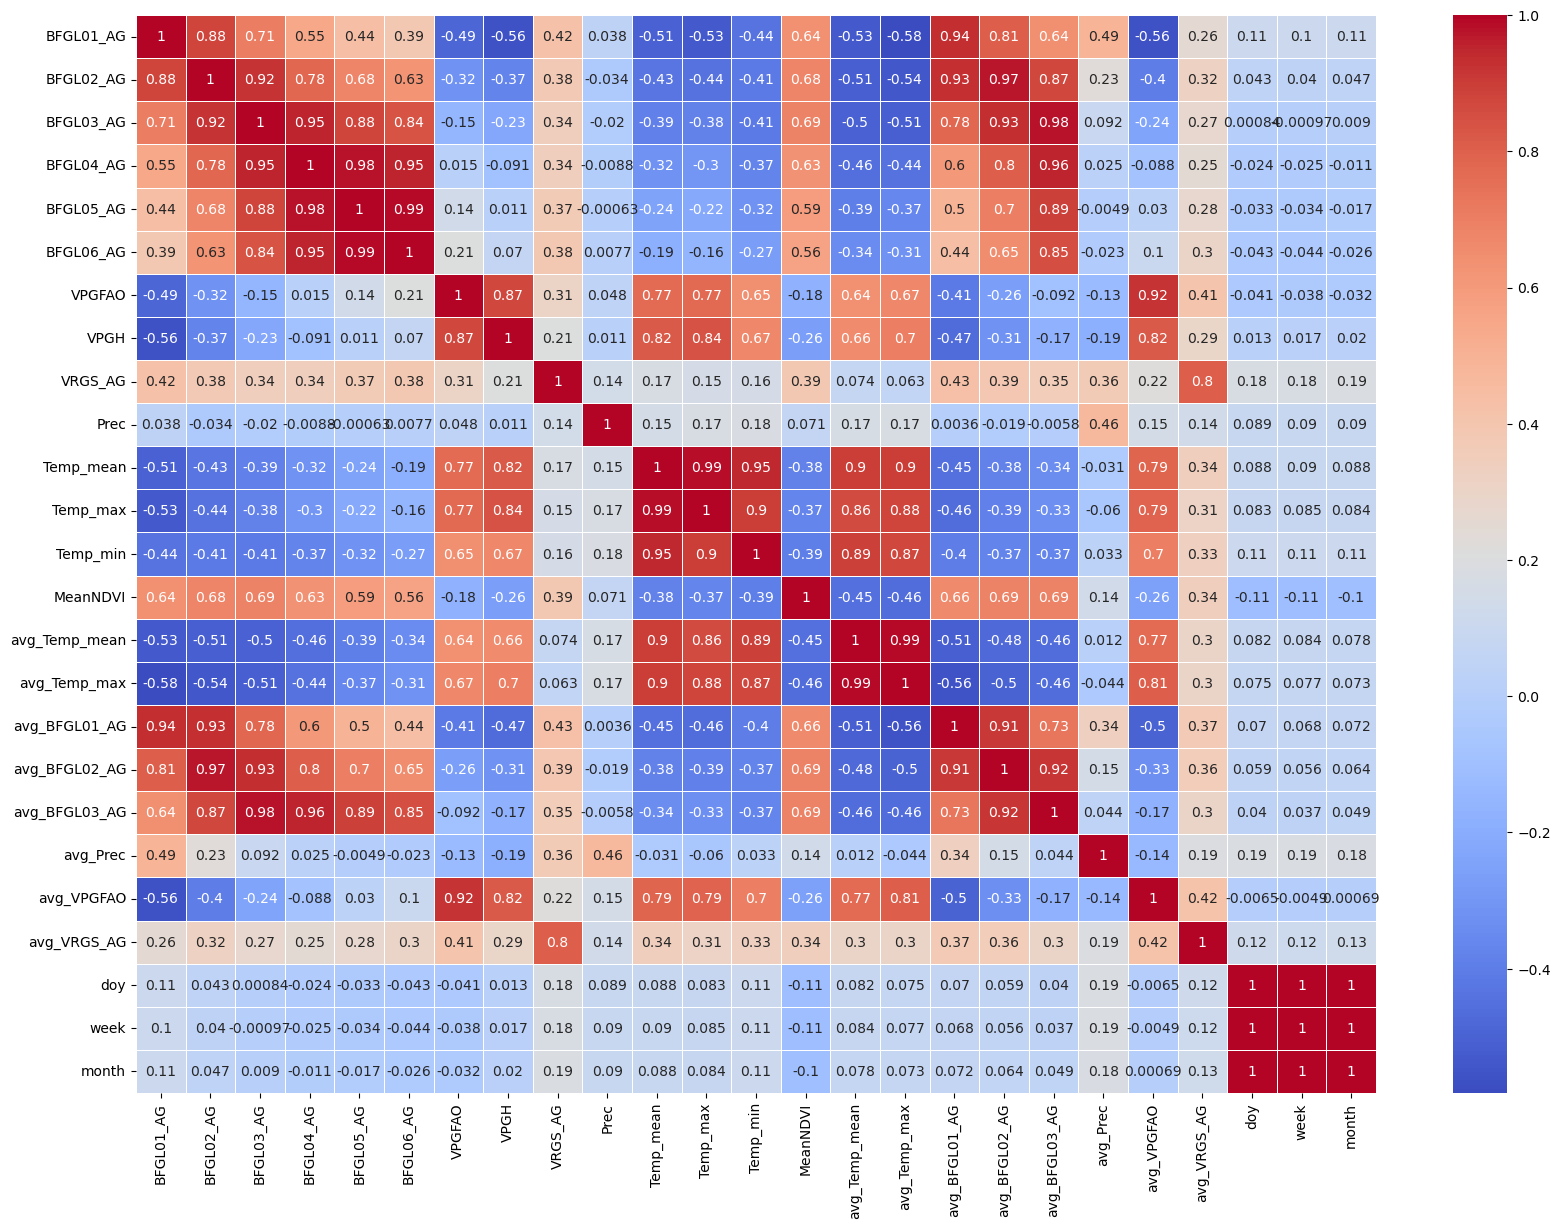

In [161]:
corr_matrix = df_rf.corr()

# Visualise
plt.figure(figsize=(20, 14)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.show()

### Building the model

selected features will now be included into random forest 

In [174]:
X = df_rf[[
 'avg_VPGFAO',
 'BFGL02_AG',
 'avg_Temp_max',
 'avg_BFGL01_AG'
 ]]
y = df_rf['MeanNDVI']
# to double check that they have the same length
print(len(X), len(y))

197 197


In [175]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101) 

In [176]:
rfr = RandomForestRegressor(
    n_estimators=70,
    max_depth=5,  
    min_samples_split=10
)
rfr.fit(X_train, y_train)
predictions = rfr.predict(X_test)

### Lets assess the performance of the model

#### Classic metrics for assessing models, does not look too bad?

In [178]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('NSE:', nse(y_test, predictions)) #is it good?
print('RSR:', np.sqrt(metrics.mean_squared_error(y_test, predictions))/np.std(y_test)) 

MAE: 0.04584543051340974
MSE: 0.0033452105481188437
RMSE: 0.057837795152640835
NSE: 0.7764573081723843
RSR: 0.47280301588252976


#### Check out the residuals

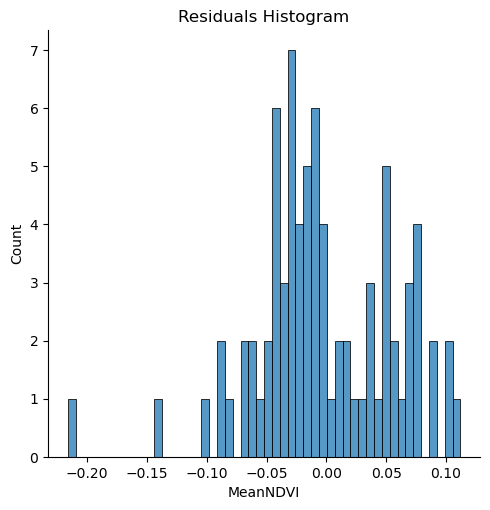

In [179]:
sns.displot((y_test-predictions),bins=50).set(title='Residuals Histogram')
plt.show()

#### K-fold cross cross validation

In [180]:
evaluate_cv_mse(rfr, X, y, Scoring='neg_mean_squared_error',cv=10)

average score: 0.004515591704054569
standard deviaton of score: 0.0031676365613028785


(0.004515591704054569, 0.0031676365613028785)

#### Lets have look at the learning curves 

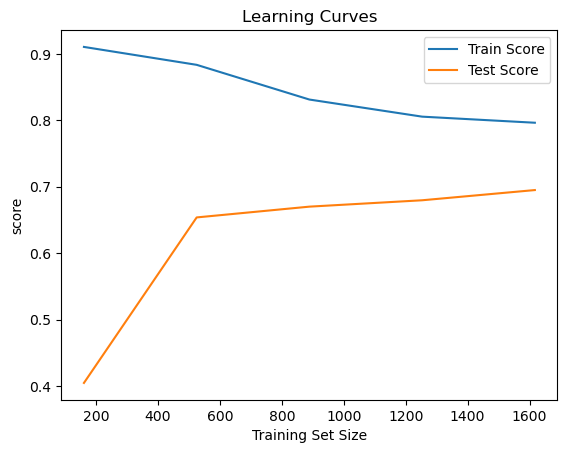

In [181]:
X, y = load_digits(return_X_y=True)
estimator = SVC(gamma=0.001)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(rfr, X, y, cv=10,return_times=True)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test Score')
plt.xlabel('Training Set Size')
plt.ylabel('score')
plt.title('Learning Curves')
plt.legend()
plt.show()

### Apply your model 
here you can use the model to predict the NDVI for days that are missing data

In [7]:
# we use the datframe we already loaded
# new df for prediction

df_model = full_df[[
'avg_VPGFAO',
 'BFGL02_AG',
 'avg_Temp_max',
 'avg_BFGL01_AG'
 ]]
set(df_model.keys()) 

{'BFGL02_AG', 'avg_BFGL01_AG', 'avg_Temp_max', 'avg_VPGFAO'}

In [16]:
# make predictions with the random forest regressor model 
predicted_ndvi = rfr.predict(df_model)


df_model['predicted_NDVI'] = predicted_ndvi
df_model.describe()

C:\Users\harder\AppData\Local\Temp\ipykernel_22364\4126459710.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['predicted_NDVI'] = predicted_ndvi


,avg_VPGFAO,BFGL02_AG,avg_Temp_max,avg_BFGL01_AG,predicted_NDVI
count,1591.000000,1603.000000,1591.000000,1591.000000,1604.000000
mean,3.111188,57.501560,20.849699,63.056748,0.588576
std,1.480740,36.155431,5.723466,34.167422,0.099901
min,0.385714,5.000000,6.914286,2.571429,0.333680
25%,1.914286,24.000000,16.578571,32.857143,0.569214
50%,3.171429,54.000000,21.571429,63.714286,0.638369
75%,4.242857,91.000000,25.392857,93.500000,0.649094
max,6.742857,128.000000,32.914286,121.857143,0.698026


In [17]:
# append the predicted NDVI to our dataframe 
full_df['predicted_ndvi'] = predicted_ndvi
full_df.columns

Index(['Stationsindex', 'Datum', 'BFGL01_AG', 'BFGL02_AG', 'BFGL03_AG',
       'BFGL04_AG', 'BFGL05_AG', 'BFGL06_AG', 'VPGFAO', 'VPGH', 'VRGS_AG',
       'Prec', 'Temp_mean', 'Temp_max', 'Temp_min', 'MeanNDVI',
       'avg_Temp_mean', 'avg_Temp_max', 'avg_BFGL01_AG', 'avg_BFGL02_AG',
       'avg_BFGL03_AG', 'avg_Prec', 'avg_VPGFAO', 'avg_VRGS_AG', 'doy', 'week',
       'month', 'predicted_ndvi'],
      dtype='object')

In [20]:
# save it 
full_df.to_csv('../../output_files/modelliert.csv', index=False, sep=";")

#### Let's see the results in a plot

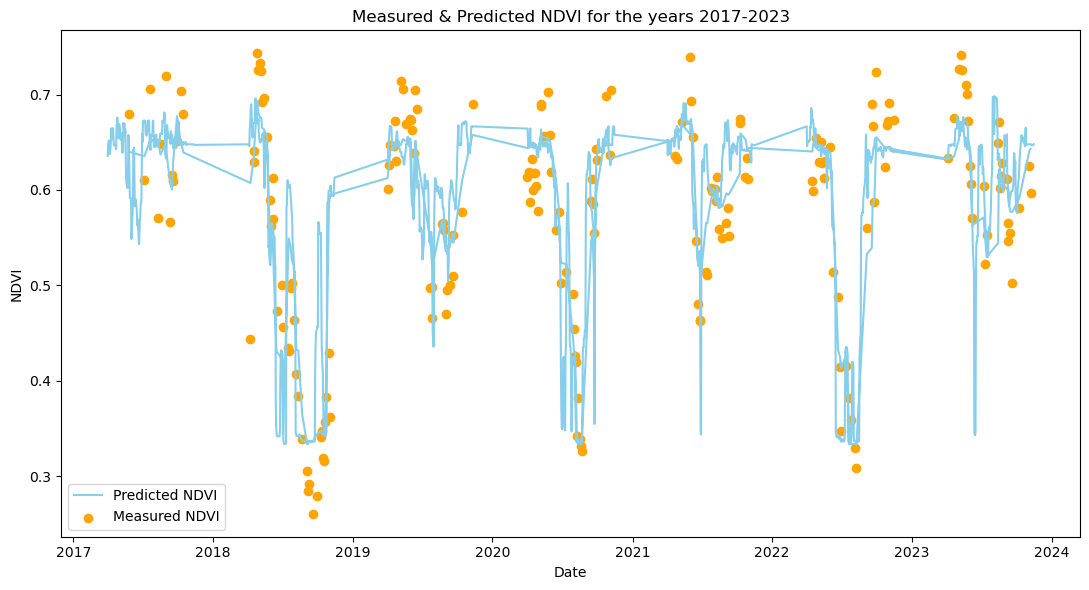

In [25]:
# Plotting the measured and predicted NDVI in one plot
plt.figure(figsize=(11, 6))

# Line plot for predicted, note: bewteen 15.11 and 1.4. there is no data thus it is only a straight line
plt.plot(full_df['Datum'], full_df['predicted_ndvi'], linestyle='-', color='skyblue', label='Predicted NDVI')

# Points for the measured NDVI data
plt.scatter(full_df['Datum'], full_df['MeanNDVI'], color='orange', label='Measured NDVI')

# Labels and title
plt.title("Measured & Predicted NDVI for the years 2017-2023")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

you have reached the end:( well done! I hope the whole process didn't cause you too much stress